# EduVerse USA Chatbot — Retrieval-Augmented Generation

## NLP Pipeline Module 5

This notebook demonstrates RAG for grounding responses in factual knowledge.

### Pipeline
1. Build knowledge base with structured documents
2. Generate semantic embeddings
3. Index for efficient similarity search
4. Retrieve relevant documents for queries

---
## 1. Setup

In [9]:
!pip install faiss-cpu -q


In [10]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = ""
os.environ["TOKENIZERS_PARALLELISM"] = "false"
import faiss
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from dataclasses import dataclass
from typing import List, Tuple
from sklearn.decomposition import PCA
from sentence_transformers import SentenceTransformer
import faiss

print("Loading embedding model...")
model = SentenceTransformer('all-MiniLM-L6-v2')
print("Setup complete")


Loading embedding model...
Setup complete


---
## 2. Knowledge Base

In [11]:
@dataclass
class Document:
    doc_id: str
    title: str
    content: str
    category: str

knowledge_base = [
    Document("adm_001", "Graduate Admission Requirements",
             "U.S. graduate programs require: transcripts, test scores (GRE/GMAT), SOP, letters of recommendation, resume. International students need TOEFL/IELTS.",
             "admissions"),
    Document("adm_002", "Application Deadlines",
             "Most universities have Fall deadlines in December-January. Early decision in October-November. Spring deadlines in September-October.",
             "admissions"),
    Document("sop_001", "Statement of Purpose Structure",
             "A strong SOP includes: motivation, academic background, research experience, program fit, career goals. Length: 500-1000 words.",
             "sop"),
    Document("sop_002", "SOP Writing Tips",
             "Be specific about why this program. Use concrete examples. Research faculty. Connect experience to goals. Proofread carefully.",
             "sop"),
    Document("sch_001", "Scholarship Types",
             "Options: merit scholarships, need-based aid, TA/RA assistantships, fellowships (Fulbright), tuition waivers.",
             "scholarships"),
    Document("sch_002", "Fulbright Program",
             "Fulbright covers tuition, living expenses, travel. Apply February, deadline October. Requires strong academics and leadership.",
             "scholarships"),
    Document("test_001", "GRE Overview",
             "GRE: Verbal (130-170), Quantitative (130-170), Analytical Writing (0-6). Total 260-340. Target 315+ for MS, 320+ for PhD.",
             "test_prep"),
    Document("test_002", "TOEFL Requirements",
             "TOEFL iBT: 0-120 total. Most universities require 80-100. Top programs expect 100+. Valid 2 years.",
             "test_prep"),
    Document("test_003", "IELTS vs TOEFL",
             "IELTS: 1-9 band. Typical requirement 6.5-7.0 (equivalent to TOEFL 90-100). IELTS has live speaking interview.",
             "test_prep")
]

print(f"Knowledge base: {len(knowledge_base)} documents")
print(f"Categories: {set(d.category for d in knowledge_base)}")


Knowledge base: 9 documents
Categories: {'admissions', 'sop', 'test_prep', 'scholarships'}


---
## 3. Generate Embeddings

In [12]:
texts = [f"{doc.title}. {doc.content}" for doc in knowledge_base]

print("Generating embeddings (batch-safe)...")
embeddings_list = []

# Encode one document at a time to reduce memory usage
for t in texts:
    emb = model.encode([t], show_progress_bar=False)
    embeddings_list.append(emb)

embeddings = np.vstack(embeddings_list).astype('float32')
print(f"Shape: {embeddings.shape}")
print(f"Dimension: {embeddings.shape[1]}")


Generating embeddings (batch-safe)...
Shape: (9, 384)
Dimension: 384


---
## 4. FAISS Index

In [13]:
dimension = embeddings.shape[1]
index = faiss.IndexFlatIP(dimension)

# Normalize embeddings for cosine similarity
faiss.normalize_L2(embeddings)

# Add embeddings to FAISS
index.add(embeddings)
print(f"FAISS index: {index.ntotal} vectors")


FAISS index: 9 vectors


---
## 5. Retrieval Function

In [14]:
def retrieve(query: str, top_k: int = 3) -> List[Tuple[Document, float]]:
    """Retrieve most relevant documents from FAISS."""
    query_emb = model.encode([query]).astype('float32')
    faiss.normalize_L2(query_emb)

    scores, indices = index.search(query_emb, top_k)

    results = [(knowledge_base[idx], float(score)) for idx, score in zip(indices[0], scores[0])]
    return results

# Test retrieval
query = "How do I write a good statement of purpose?"
results = retrieve(query)

print(f"Query: {query}")
print("\nTop Results:")
for doc, score in results:
    print(f"  [{score:.3f}] {doc.title}")


Query: How do I write a good statement of purpose?

Top Results:
  [0.595] Statement of Purpose Structure
  [0.479] SOP Writing Tips
  [0.109] Graduate Admission Requirements


---
## 6. Test Multiple Queries

In [15]:
test_queries = [
    "What GRE score do I need?",
    "Scholarships for international students",
    "TOEFL vs IELTS which is better?",
    "Application deadline for fall"
]

print("Retrieval Results")
print("=" * 60)

for query in test_queries:
    results = retrieve(query, top_k=2)
    print(f"\nQuery: {query}")
    for doc, score in results:
        print(f"  → [{doc.category}] {doc.title} ({score:.3f})")


Retrieval Results

Query: What GRE score do I need?
  → [test_prep] GRE Overview (0.681)
  → [admissions] Graduate Admission Requirements (0.550)

Query: Scholarships for international students
  → [scholarships] Scholarship Types (0.669)
  → [scholarships] Fulbright Program (0.510)

Query: TOEFL vs IELTS which is better?
  → [test_prep] IELTS vs TOEFL (0.712)
  → [test_prep] TOEFL Requirements (0.478)

Query: Application deadline for fall
  → [admissions] Application Deadlines (0.755)
  → [test_prep] TOEFL Requirements (0.234)


---
## 7. Embedding Space Visualization

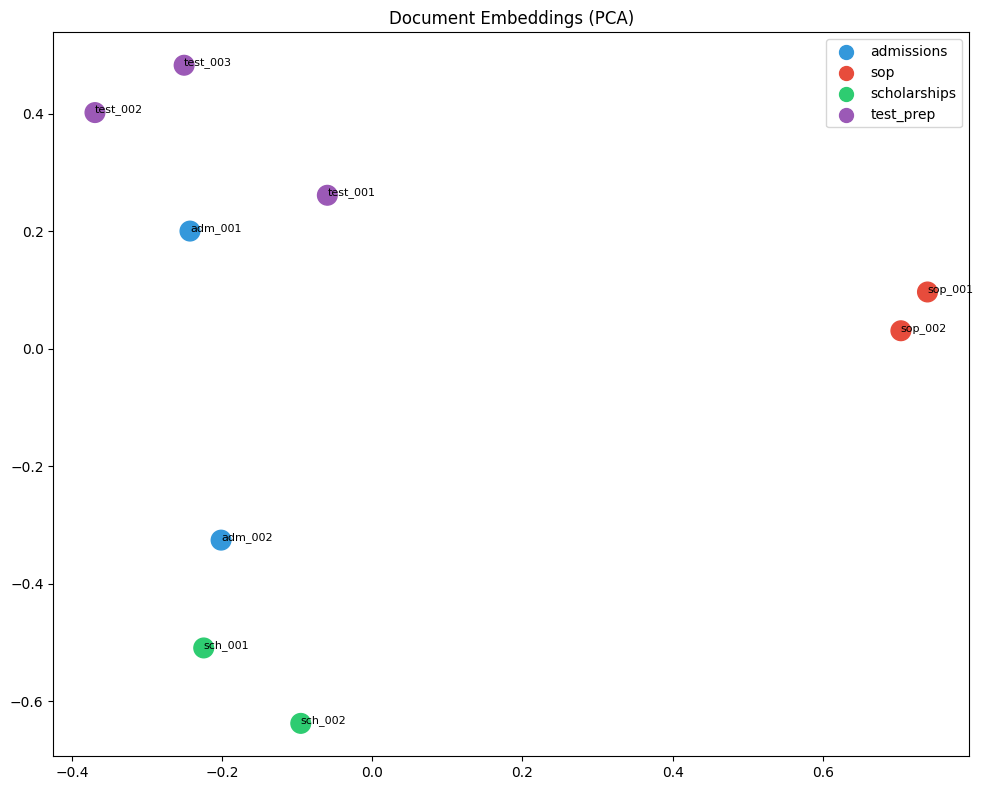

In [16]:
# Reduce embeddings to 2D using PCA
pca = PCA(n_components=2, random_state=42)
emb_2d = pca.fit_transform(embeddings)

# Category colors
category_colors = {
    'admissions': '#3498db',
    'sop': '#e74c3c',
    'scholarships': '#2ecc71',
    'test_prep': '#9b59b6'
}
colors = [category_colors[doc.category] for doc in knowledge_base]

# Plot
plt.figure(figsize=(10, 8))
plt.scatter(emb_2d[:, 0], emb_2d[:, 1], c=colors, s=200)

# Annotate each point with doc_id
for i, doc in enumerate(knowledge_base):
    plt.annotate(doc.doc_id, (emb_2d[i, 0], emb_2d[i, 1]), fontsize=8)

# Legend
for cat, color in category_colors.items():
    plt.scatter([], [], c=color, s=100, label=cat)
plt.legend()
plt.title('Document Embeddings (PCA)')
plt.tight_layout()
plt.show()


---
## 8. RAG Pipeline

In [17]:
def rag_response(query: str, top_k: int = 2) -> dict:
    """Retrieve documents and prepare RAG-style context."""
    retrieved = retrieve(query, top_k)

    context = []
    sources = []

    for doc, score in retrieved:
        if score > 0.3:  # relevance threshold
            context.append(doc.content)
            sources.append({'id': doc.doc_id, 'title': doc.title, 'score': round(score, 3)})

    return {
        'query': query,
        'context': ' '.join(context),
        'sources': sources
    }

# Test RAG pipeline
result = rag_response("What are graduate admission requirements?")

print("RAG Output")
print("=" * 60)
print(f"Query: {result['query']}")
print("\nSources:")
for src in result['sources']:
    print(f"  - {src['title']} ({src['score']})")
print(f"\nContext: {result['context'][:200]}...")


RAG Output
Query: What are graduate admission requirements?

Sources:
  - Graduate Admission Requirements (0.707)
  - GRE Overview (0.476)

Context: U.S. graduate programs require: transcripts, test scores (GRE/GMAT), SOP, letters of recommendation, resume. International students need TOEFL/IELTS. GRE: Verbal (130-170), Quantitative (130-170), Ana...


---
## 9. Summary

### RAG Components
- **Knowledge base** with structured documents
- **Semantic embeddings** using Sentence Transformers
- **FAISS indexing** for efficient search
- **Context building** for response grounding

### Key Takeaways
1. Semantic search finds relevant content without exact matches
2. Embedding visualization shows category clustering
3. Relevance thresholds filter low-quality matches
4. Source attribution enables fact verification